# Using torch.nn.LSTM

Training Model 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

Training Model 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

Training Model 3/10:   0%|          | 0/150 [00:00<?, ?it/s]

Training Model 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

Training Model 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

Training Model 6/10:   0%|          | 0/150 [00:00<?, ?it/s]

Training Model 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

Training Model 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

Training Model 9/10:   0%|          | 0/150 [00:00<?, ?it/s]

Training Model 10/10:   0%|          | 0/200 [00:00<?, ?it/s]

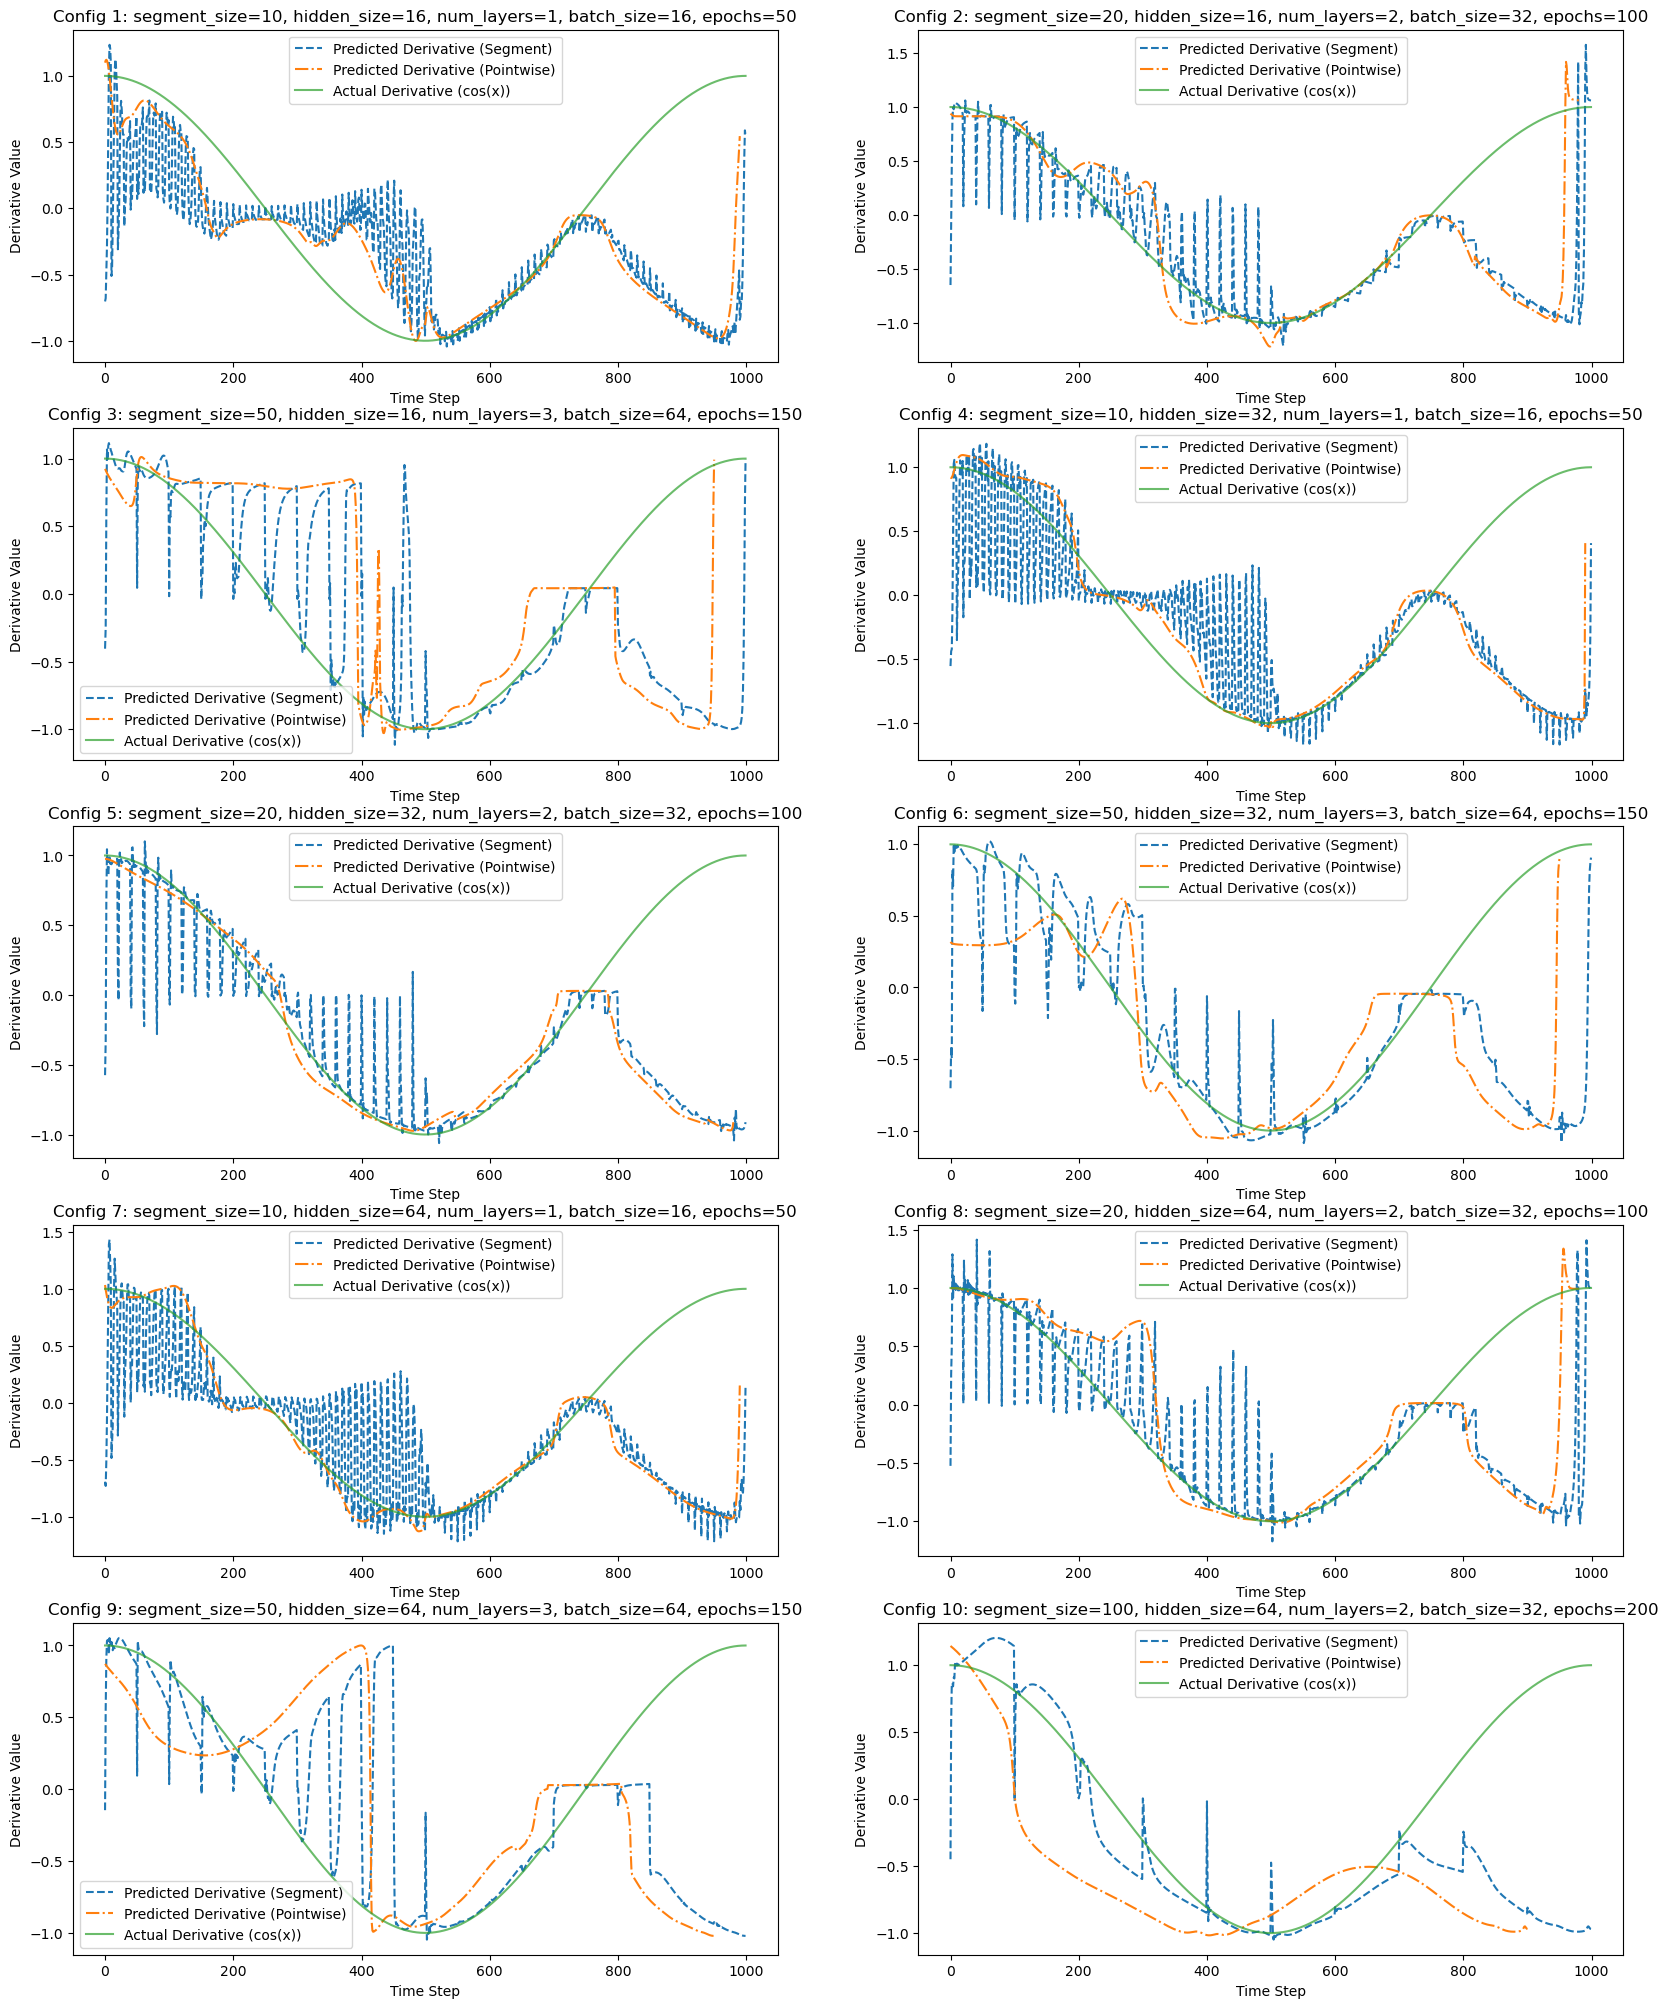

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Seed for reproducibility
torch.manual_seed(0)

### CREATE DATASET ###
time = np.linspace(0, 2 * np.pi, 1000)
time = time[:800]

sin_x = np.sin(time)
derivative = np.cos(time)  # Derivative of sin(x) is cos(x)

seq_length = 10
X = torch.tensor([sin_x[i: i + seq_length] for i in range(len(sin_x) - seq_length)], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor([derivative[i: i + seq_length] for i in range(len(derivative) - seq_length)],
                 dtype=torch.float32).unsqueeze(-1)

### TEST CONFIGURATIONS ###
test_configs = [
    {'segment_size': 10, 'hidden_size': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 50},
    {'segment_size': 20, 'hidden_size': 16, 'num_layers': 2, 'batch_size': 32, 'epochs': 100},
    {'segment_size': 50, 'hidden_size': 16, 'num_layers': 3, 'batch_size': 64, 'epochs': 150},
    {'segment_size': 10, 'hidden_size': 32, 'num_layers': 1, 'batch_size': 16, 'epochs': 50},
    {'segment_size': 20, 'hidden_size': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 100},
    {'segment_size': 50, 'hidden_size': 32, 'num_layers': 3, 'batch_size': 64, 'epochs': 150},
    {'segment_size': 10, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 16, 'epochs': 50},
    {'segment_size': 20, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 32, 'epochs': 100},
    {'segment_size': 50, 'hidden_size': 64, 'num_layers': 3, 'batch_size': 64, 'epochs': 150},
    {'segment_size': 100, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 32, 'epochs': 200}
]

### SET UP SUBPLOTS ###
fig, axs = plt.subplots(5, 2, figsize=(20, 25))
axs = axs.ravel()

### RUN TESTS ###
for i, config in enumerate(test_configs):
    # Create LSTM model with current configuration
    class SimpleLSTM(nn.Module):
        def __init__(self, input_size=1, hidden_size=config['hidden_size'], num_layers=config['num_layers']):
            super(SimpleLSTM, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # or use the custom one 
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out)
            return out


    model = SimpleLSTM()
    model.to("cuda")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    batch_size = config['batch_size']
    num_epochs = config['epochs']
    dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, Y), batch_size=batch_size, shuffle=True)

    # Train the model
    for epoch in tqdm(range(num_epochs), desc=f"Training Model {i + 1}/{len(test_configs)}"):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to("cuda"), targets.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    ### EVALUATE ###
    test_length = 1000  # Full period for evaluation
    segment_size = config['segment_size']
    predicted_derivative_segment = []
    predicted_derivative_pointwise = []

    val_sin_x = np.sin(np.linspace(0, 2 * np.pi, 1000))
    val_derivative = np.cos(np.linspace(0, 2 * np.pi, 1000))

    # Segment-based predictions
    for start in range(0, test_length, segment_size):
        end = min(start + segment_size, test_length)
        test_inputs = torch.tensor(val_sin_x[start:end], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        with torch.no_grad():
            test_inputs = test_inputs.to("cuda")
            segment_outputs = model(test_inputs)
            predicted_derivative_segment.extend(segment_outputs.cpu().detach().numpy().flatten())

    # Pointwise predictions but keep segment size
    for start in range(0, test_length - segment_size + 1):
        end = start + segment_size
        test_input = torch.tensor(val_sin_x[start:end], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        with torch.no_grad():
            test_input = test_input.to("cuda")
            predicted_output = model(test_input)
            predicted_derivative_pointwise.append(predicted_output.cpu().detach().numpy().flatten()[-1])

    # Plot results
    axs[i].plot(predicted_derivative_segment, label="Predicted Derivative (Segment)", linestyle="--")
    axs[i].plot(predicted_derivative_pointwise, label="Predicted Derivative (Pointwise)", linestyle="-.")
    axs[i].plot(val_derivative, label="Actual Derivative (cos(x))", alpha=0.7)
    axs[i].set_title(
        f"Config {i + 1}: segment_size={config['segment_size']}, hidden_size={config['hidden_size']}, num_layers={config['num_layers']}, batch_size={config['batch_size']}, epochs={config['epochs']}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Derivative Value")
    axs[i].legend()

plt.show()

# Now Using my MultilayerCustomLSTM

Training Model 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

Training Model 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

Training Model 3/10:   0%|          | 0/150 [00:00<?, ?it/s]

Training Model 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

Training Model 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

Training Model 6/10:   0%|          | 0/150 [00:00<?, ?it/s]

Training Model 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

Training Model 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

Training Model 9/10:   0%|          | 0/150 [00:00<?, ?it/s]

Training Model 10/10:   0%|          | 0/200 [00:00<?, ?it/s]

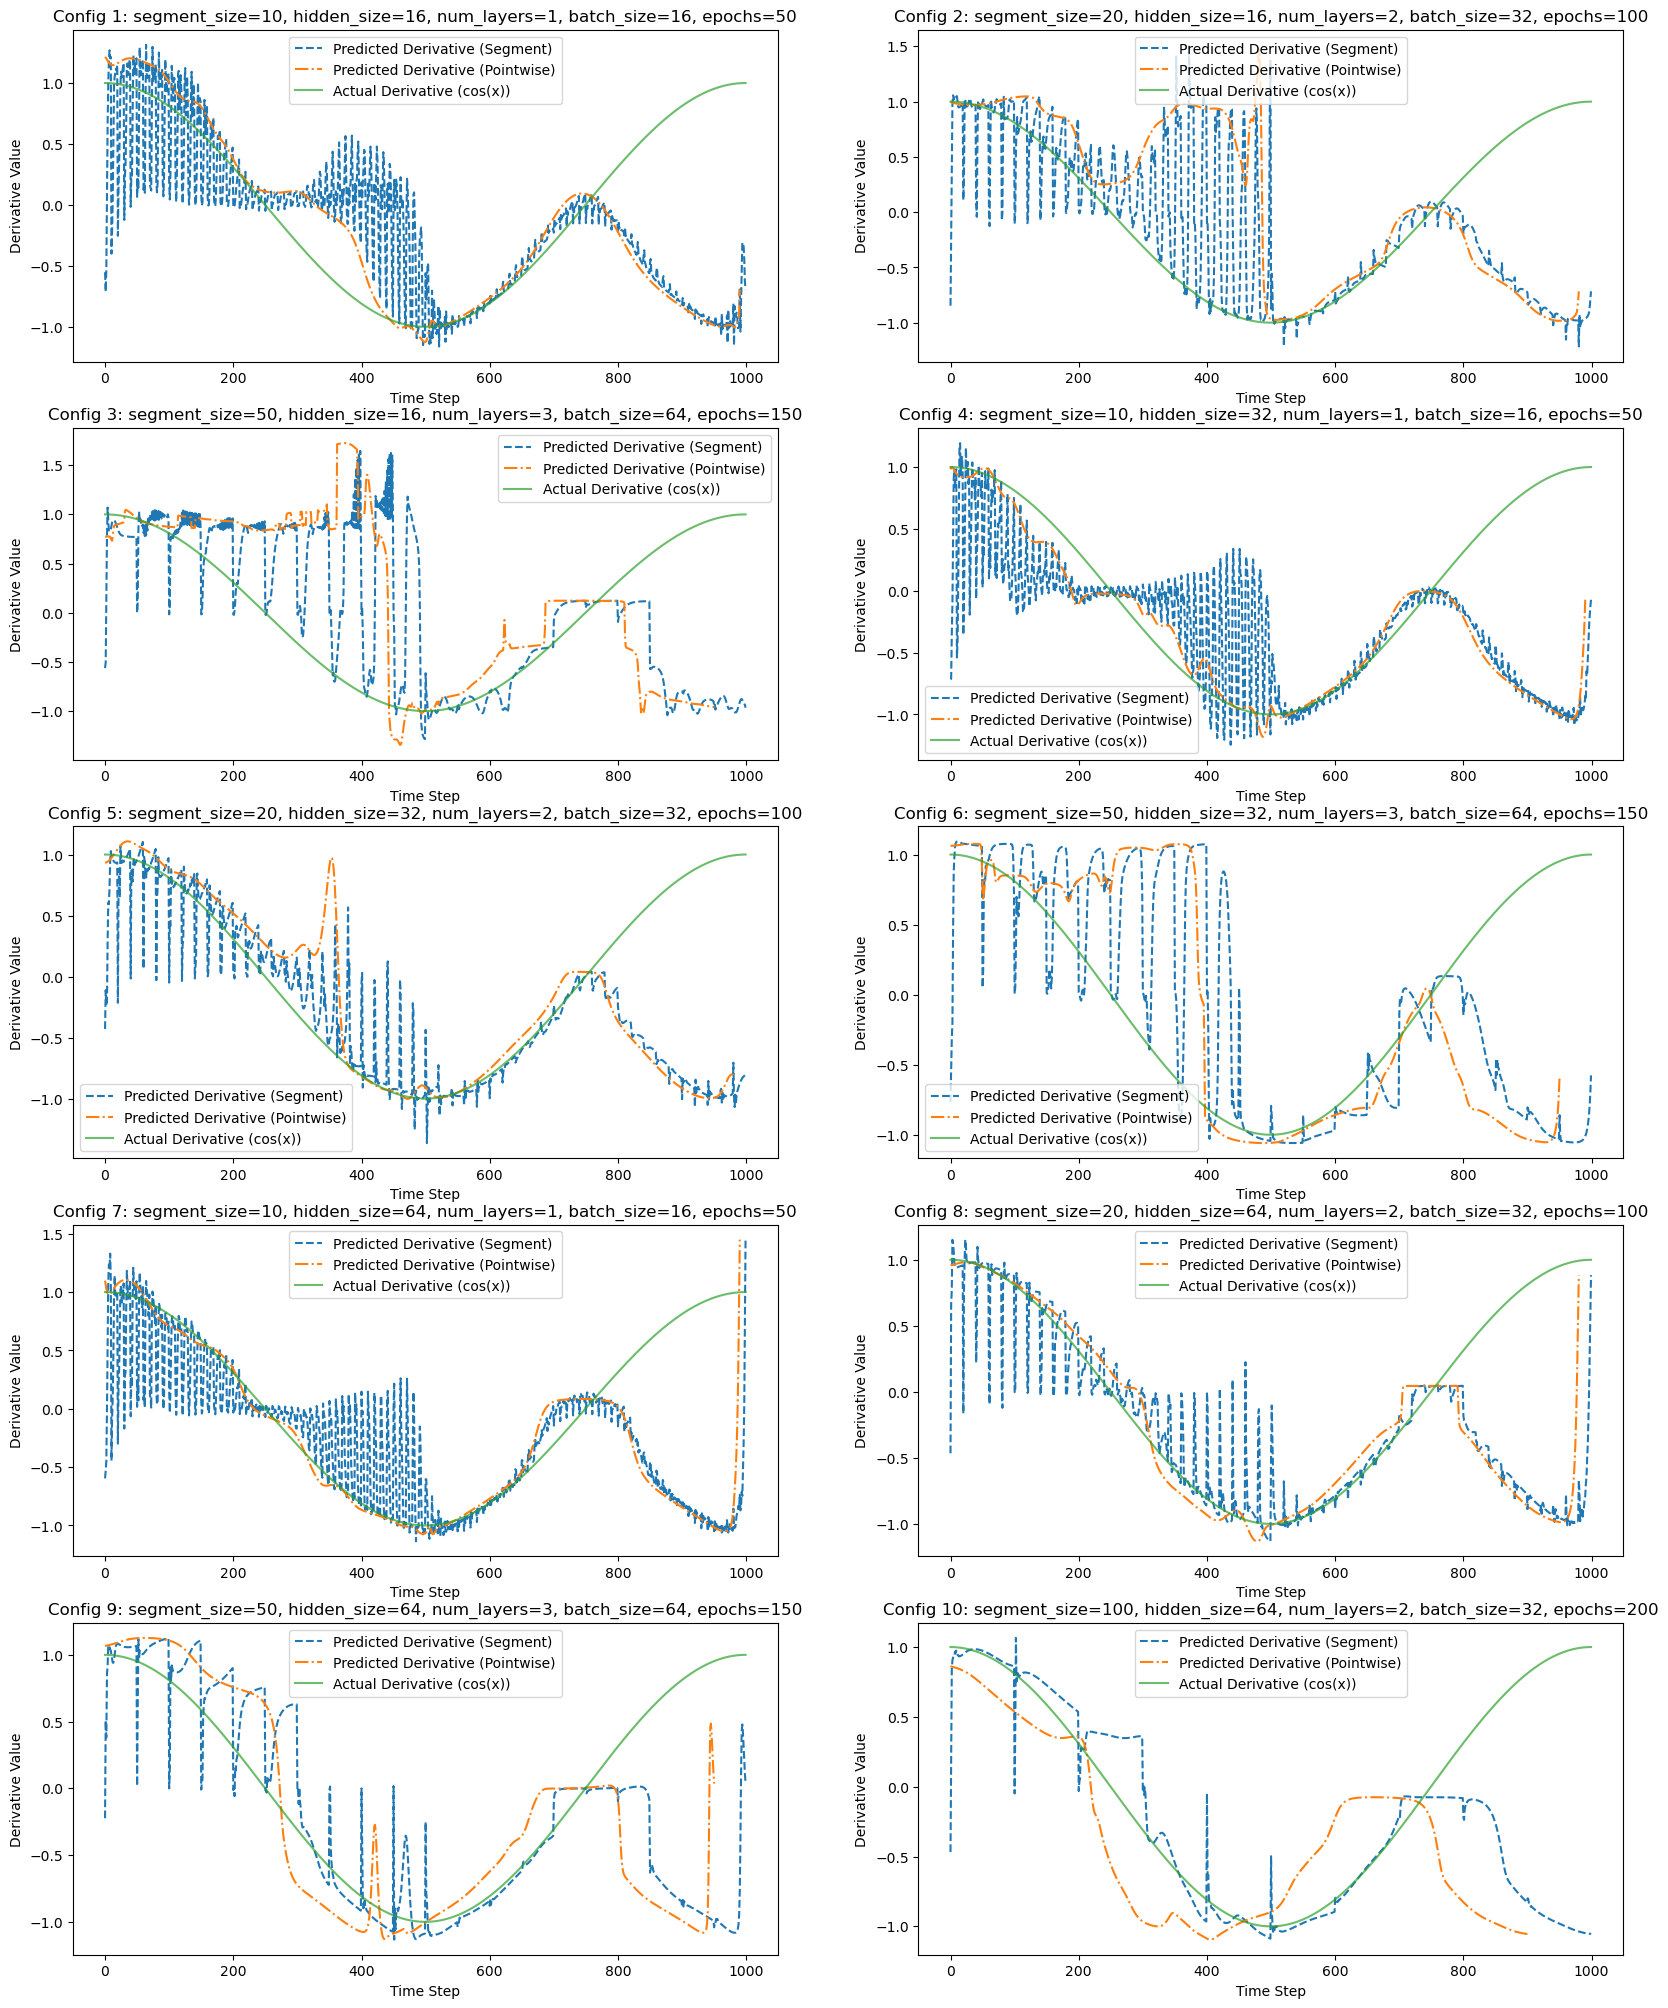

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from custom_lstm import MultiLayerCustomLSTM

# Seed for reproducibility
torch.manual_seed(0)

### CREATE DATASET ###
time = np.linspace(0, 2 * np.pi, 1000)
time = time[:800]

sin_x = np.sin(time)
derivative = np.cos(time)  # Derivative of sin(x) is cos(x)

seq_length = 10
X = torch.tensor([sin_x[i: i + seq_length] for i in range(len(sin_x) - seq_length)], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor([derivative[i: i + seq_length] for i in range(len(derivative) - seq_length)],
                 dtype=torch.float32).unsqueeze(-1)

### TEST CONFIGURATIONS ###
test_configs = [
    {'segment_size': 10, 'hidden_size': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 50},
    {'segment_size': 20, 'hidden_size': 16, 'num_layers': 2, 'batch_size': 32, 'epochs': 100},
    {'segment_size': 50, 'hidden_size': 16, 'num_layers': 3, 'batch_size': 64, 'epochs': 150},
    {'segment_size': 10, 'hidden_size': 32, 'num_layers': 1, 'batch_size': 16, 'epochs': 50},
    {'segment_size': 20, 'hidden_size': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 100},
    {'segment_size': 50, 'hidden_size': 32, 'num_layers': 3, 'batch_size': 64, 'epochs': 150},
    {'segment_size': 10, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 16, 'epochs': 50},
    {'segment_size': 20, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 32, 'epochs': 100},
    {'segment_size': 50, 'hidden_size': 64, 'num_layers': 3, 'batch_size': 64, 'epochs': 150},
    {'segment_size': 100, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 32, 'epochs': 200}
]

### SET UP SUBPLOTS ###
fig, axs = plt.subplots(5, 2, figsize=(20, 25))
axs = axs.ravel()

### RUN TESTS ###
for i, config in enumerate(test_configs):
    # Create LSTM model with current configuration
    class SimpleLSTM(nn.Module):
        def __init__(self, input_size=1, hidden_size=config['hidden_size'], num_layers=config['num_layers']):
            super(SimpleLSTM, self).__init__()
            self.lstm = MultiLayerCustomLSTM(input_size, hidden_size, num_layers)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out)
            return out


    model = SimpleLSTM()
    model.to("cuda")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    batch_size = config['batch_size']
    num_epochs = config['epochs']
    dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, Y), batch_size=batch_size, shuffle=True)

    # Train the model
    for epoch in tqdm(range(num_epochs), desc=f"Training Model {i + 1}/{len(test_configs)}"):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to("cuda"), targets.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    ### EVALUATE ###
    test_length = 1000  # Full period for evaluation
    segment_size = config['segment_size']
    predicted_derivative_segment = []
    predicted_derivative_pointwise = []

    val_sin_x = np.sin(np.linspace(0, 2 * np.pi, 1000))
    val_derivative = np.cos(np.linspace(0, 2 * np.pi, 1000))

    # Segment-based predictions
    for start in range(0, test_length, segment_size):
        end = min(start + segment_size, test_length)
        test_inputs = torch.tensor(val_sin_x[start:end], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        with torch.no_grad():
            test_inputs = test_inputs.to("cuda")
            segment_outputs = model(test_inputs)
            predicted_derivative_segment.extend(segment_outputs.cpu().detach().numpy().flatten())

    # Pointwise predictions but keep segment size
    for start in range(0, test_length - segment_size + 1):
        end = start + segment_size
        test_input = torch.tensor(val_sin_x[start:end], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        with torch.no_grad():
            test_input = test_input.to("cuda")
            predicted_output = model(test_input)
            predicted_derivative_pointwise.append(predicted_output.cpu().detach().numpy().flatten()[-1])

    # Plot results
    axs[i].plot(predicted_derivative_segment, label="Predicted Derivative (Segment)", linestyle="--")
    axs[i].plot(predicted_derivative_pointwise, label="Predicted Derivative (Pointwise)", linestyle="-.")
    axs[i].plot(val_derivative, label="Actual Derivative (cos(x))", alpha=0.7)
    axs[i].set_title(
        f"Config {i + 1}: segment_size={config['segment_size']}, hidden_size={config['hidden_size']}, num_layers={config['num_layers']}, batch_size={config['batch_size']}, epochs={config['epochs']}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Derivative Value")
    axs[i].legend()

plt.show()
